# Comparing random forest classifier performance

In [ ]:
"""Comparing random forest classifier performance

"""

In [ ]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# import data
df = pd.read_csv('data/SCADA_and_downtime.csv', skip_blank_lines=True)

In [ ]:
# list of turbines to plot
list1 = list(df['turbine_id'].unique())
# sort turbines in ascending order
list1 = sorted(list1, key=int)
# list of categories
list2 = list(df['TurbineCategory_id'].unique())
# remove NaN from list
list2 = [g for g in list2 if g >= 0]
# sort categories in ascending order
list2 = sorted(list2, key=int)
# categories to remove
list2 = [m for m in list2 if m not in (1, 12, 13, 14, 15, 17, 21, 22)]
# empty list to hold optimal n values for all turbines
num = []
# empty list to hold minimum error readings for all turbines
err = []

The optimal number of trees in the forest for turbine 1 is 29


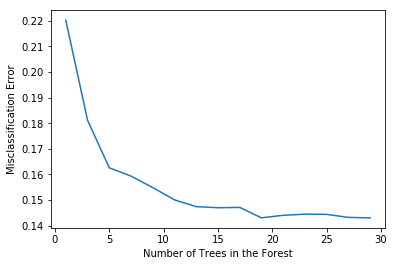

The optimal number of trees in the forest for turbine 2 is 17


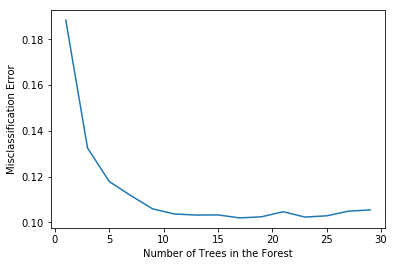

The optimal number of trees in the forest for turbine 3 is 29


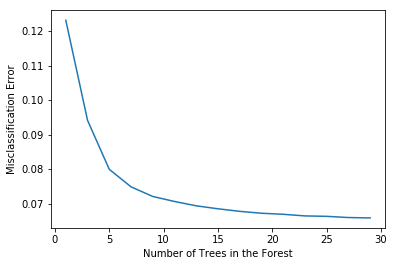

The optimal number of trees in the forest for turbine 4 is 27


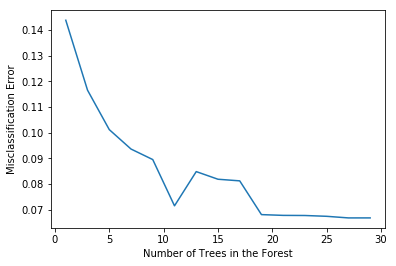

The optimal number of trees in the forest for turbine 5 is 11


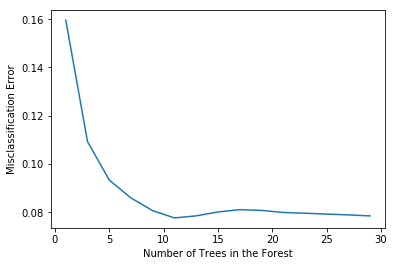

The optimal number of trees in the forest for turbine 6 is 3


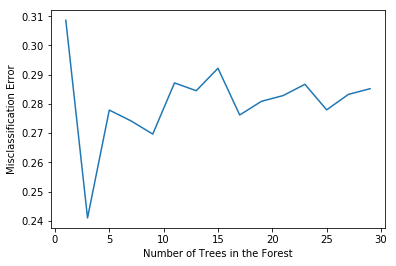

The optimal number of trees in the forest for turbine 7 is 27


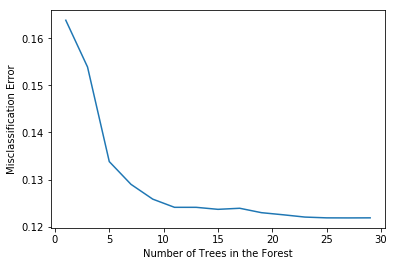

The optimal number of trees in the forest for turbine 8 is 29


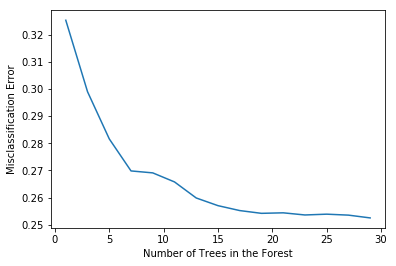

The optimal number of trees in the forest for turbine 9 is 25


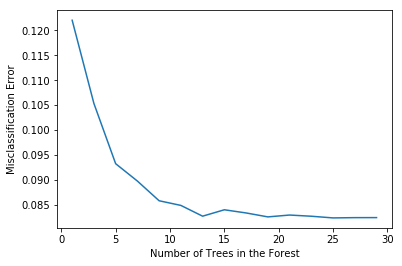

The optimal number of trees in the forest for turbine 10 is 29


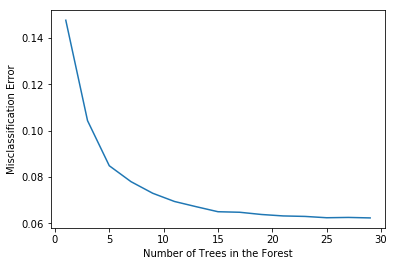

The optimal number of trees in the forest for turbine 11 is 29


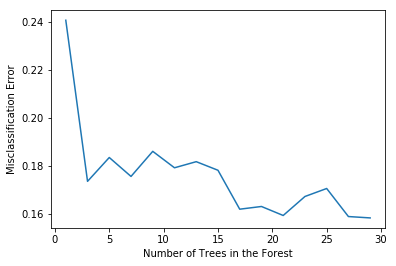

The optimal number of trees in the forest for turbine 12 is 21


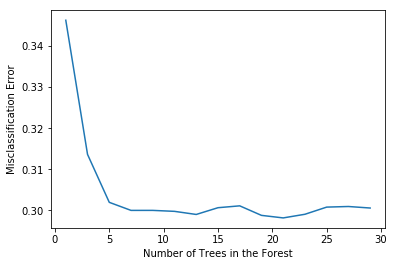

In [ ]:
# filter only data for turbine x
for x in list1:
    dfx = df[(df['turbine_id'] == x)].copy()

    # copying fault to new column (mins) (fault when turbine category id is y)
    for y in list2:
        def f(c):
            if c['TurbineCategory_id'] == y:
                return 0
            else:
                return 1
        dfx['mins'] = dfx.apply(f, axis=1)

        # sort values by timestamp in descending order
        dfx = dfx.sort_values(by='timestamp', ascending=False)
        # reset index
        dfx.reset_index(drop=True, inplace=True)

        # assigning value to first cell if it's not 0 with a large number
        if dfx.loc[0, 'mins'] == 0:
            dfx.set_value(0, 'mins', 0)
        else:
            # to allow the following loop to work
            dfx.set_value(0, 'mins', 999999999)

        # using previous value's row to evaluate time
        for i, e in enumerate(dfx['mins']):
            if e == 1:
                dfx.at[i, 'mins'] = dfx.at[i - 1, 'mins'] + 10

        # sort in ascending order
        dfx = dfx.sort_values(by='timestamp')
        # reset index
        dfx.reset_index(drop=True, inplace=True)
        # convert to hours, then round to nearest hour
        dfx['hours'] = dfx['mins'].astype(np.int64)
        dfx['hours'] = dfx['hours']/60
        # round to integer
        dfx['hours'] = round(dfx['hours']).astype(np.int64)

        # > 48 hours - label as normal (999)
        def f1(c):
            if c['hours'] > 48:
                return 999
            else:
                return c['hours']
        dfx['hours'] = dfx.apply(f1, axis=1)

        # filter out curtailment - curtailed when turbine is pitching outside
        # 0deg <= normal <= 3.5deg
        def f2(c):
            if 0 <= c['pitch'] <= 3.5 or c['hours'] != 999 or (
                    (c['pitch'] > 3.5 or c['pitch'] < 0) and (
                        c['ap_av'] <= (.1 * dfx['ap_av'].max()) or
                        c['ap_av'] >= (.9 * dfx['ap_av'].max()))):
                return 'normal'
            else:
                return 'curtailed'
        dfx['curtailment'] = dfx.apply(f2, axis=1)

        # filter unusual readings, i.e., for normal operation, power <= 0 in
        # operating wind speeds, power > 100 ...
        def f3(c):
            # before cut-in, runtime < 600 and other downtime categories
            if c['hours'] == 999 and ((
                        3 < c['ws_av'] < 25 and (
                            c['ap_av'] <= 0 or
                            c['runtime'] < 600 or
                            c['EnvironmentalCategory_id'] > 1 or
                            c['GridCategory_id'] > 1 or
                            c['InfrastructureCategory_id'] > 1 or
                            c['AvailabilityCategory_id'] == 2 or
                            12 <= c['TurbineCategory_id'] <= 15 or
                            21 <= c['TurbineCategory_id'] <= 22)) or
                    (c['ws_av'] < 3 and c['ap_av'] > 100)):
                return 'unusual'
            else:
                return 'normal'
        dfx['unusual'] = dfx.apply(f3, axis=1)

        # round to 6 hour intervals to reduce number of classes
        def f4(c):
            if 1 <= c['hours'] <= 6:
                return 6
            elif 7 <= c['hours'] <= 12:
                return 12
            elif 13 <= c['hours'] <= 18:
                return 18
            elif 19 <= c['hours'] <= 24:
                return 24
            elif 25 <= c['hours'] <= 30:
                return 30
            elif 31 <= c['hours'] <= 36:
                return 36
            elif 37 <= c['hours'] <= 42:
                return 42
            elif 43 <= c['hours'] <= 48:
                return 48
            else:
                return c['hours']
        dfx['hours6'] = dfx.apply(f4, axis=1)

        # change label for unusual and curtailed data (9999), if originally
        # labelled as normal
        def f5(c):
            if c['unusual'] == 'unusual' or c['curtailment'] == 'curtailed':
                return 9999
            else:
                return c['hours6']
        # apply to new column specific to each fault
        dfx['hours_%s' % y] = dfx.apply(f5, axis=1)

        # drop unnecessary columns
        dfx = dfx.drop('hours6', axis=1)
        dfx = dfx.drop('hours', axis=1)
        dfx = dfx.drop('mins', axis=1)
        dfx = dfx.drop('curtailment', axis=1)
        dfx = dfx.drop('unusual', axis=1)

    features = [
        'ap_av', 'ws_av', 'wd_av', 'pitch', 'ap_max', 'ap_dev',
        'reactive_power', 'rs_av', 'gen_sp', 'nac_pos']
    # separate features from classes for classification
    classes = [col for col in dfx.columns if 'hours' in col]
    # list of columns to copy into new df
    list3 = features + classes + ['timestamp']
    df2 = dfx[list3].copy()
    # drop NaNs
    df2 = df2.dropna()
    X = df2[features]
    # normalise features to values b/w 0 and 1
    X = preprocessing.normalize(X)
    Y = df2[classes]
    # convert from pd dataframe to np array
    Y = Y.as_matrix()

    # evaluating optimal number of trees
    # creating odd list of n
    myList = list(range(1, 30))
    # subsetting just the odd ones
    estimators = list(filter(lambda x: x % 2 != 0, myList))
    # empty list that will hold average cross validation scores for each n
    scores = []
    # cross validation using time series split
    tscv = TimeSeriesSplit(n_splits=5)

    # looping for each value of n and defining random forest classifier
    for n in estimators:
        rf = RandomForestClassifier(
            criterion='entropy', class_weight='balanced_subsample',
            random_state=42, n_estimators=n, n_jobs=-1)
        # empty list to hold score for each cross validation fold
        p1 = []
        # looping for each cross validation fold
        for train_index, test_index in tscv.split(X):
            # split train and test sets
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            # fit to classifier and predict
            rf1 = rf.fit(X_train, Y_train)
            pred = rf1.predict(X_test)
            # accuracy score
            p2 = np.sum(
                np.equal(np.array(Y_test), pred))/np.array(Y_test).size
            # add to list
            p1.append(p2)
        # average score across all cross validation folds
        p = sum(p1)/len(p1)
        scores.append(p)
    # changing to misclassification error
    MSE = [1 - x for x in scores]
    # determining best n
    optimal_n = estimators[MSE.index(min(MSE))]
    num.append(optimal_n)
    err.append(min(MSE))

    print(
        'The optimal number of trees in the forest for turbine %s' % x +
        ' is %d' % optimal_n)
    # plot misclassification error vs n
    plt.plot(estimators, MSE)
    plt.xlabel('Number of Trees in the Forest')
    plt.ylabel('Misclassification Error')
    plt.show()

In [ ]:
d = pd.DataFrame(num, columns='number of estimators')
d['error'] = err
d['turbine'] = list1

In [14]:
scores

[0.77976540313618969,
 0.81880479071490309,
 0.83739062435691647,
 0.84063958513396708,
 0.84513149771576734,
 0.84991562744371729,
 0.85255875210931387,
 0.85299748940198383,
 0.85286825534016553,
 0.85693953986088833,
 0.85595094044532249,
 0.85549738650862239,
 0.85559287154792774,
 0.85676503272008886,
 0.85697411203029183,
 0.85644235913898825,
 0.85688768160678275,
 0.85690332139770342,
 0.85704490266288003,
 0.85644071284520729,
 0.85609169856360867,
 0.85617236695888388,
 0.85644647487344128]